# XGBoost Classification with XAI (SHAP)
## Breast Cancer PAM50 Subtype Classification

This notebook demonstrates:
- XGBoost model training with hyperparameter tuning
- Model evaluation and performance metrics
- SHAP-based explainability (Global & Local)
- Model saving and loading

In [2]:
# Cell 1: Imports
import sys
import os

# Add parent directory to path for Utils import
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import shap

from Utils import visualization as viz
from Utils import model
from Utils import explainer

# Ensure plots display inline
%matplotlib inline

## 1. Data Loading and Preprocessing

In [3]:
# Loading Dataset
df = model.load_dataset(ide="local-linux")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1218, 20532)


,sampleID,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,PAM50Call_RNAseq
0,TCGA-AR-A5QQ-01,9.5074,1.5787,0.0000,11.3676,11.1292,9.9722,11.5966,3.2396,0.0000,...,0.0000,5.3307,0.5819,9.1928,13.8808,7.3830,11.4289,7.8456,10.7384,NaN
1,TCGA-D8-A1JA-01,7.4346,3.6607,0.6245,11.9181,13.5273,10.8702,12.3048,2.5547,0.0000,...,0.0000,3.1017,3.7793,9.8340,10.7066,7.2467,9.1673,0.0000,10.1225,Her2
2,TCGA-BH-A0BQ-01,9.3216,2.7224,0.5526,11.9665,11.4105,10.4406,12.8186,4.7115,0.0000,...,2.7224,4.2976,0.0000,9.2304,12.9973,8.3374,11.3400,8.3765,9.9367,LumA
3,TCGA-BH-A0BT-01,9.0198,1.3414,0.0000,13.1881,11.0911,10.4244,12.6427,2.7553,0.0000,...,2.9823,4.3067,0.0000,8.7816,12.3298,7.7036,11.3025,7.0585,9.3784,LumA
4,TCGA-A8-A06X-01,9.6417,0.5819,0.0000,12.0036,11.2545,10.1480,12.6622,4.2765,1.8007,...,0.5819,3.5764,0.0000,9.3024,11.3338,7.7186,10.6898,7.0992,11.1740,LumB


In [4]:
# Data Cleaning
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (956, 20532)


In [5]:
# Label Targeting and Feature Selection
label = df.columns[-1]
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_cols = [c for c in numeric_cols if c != label]

print(f"Target column: {label}")
print(f"Number of features: {len(feature_cols)}")

# Preparing Feature Matrix and Target Vector
X = df[feature_cols].values
y_raw = df[label].values

# Label Encoding the Target Variable
le = LabelEncoder()
y = le.fit_transform(df[label])

class_names = le.classes_
print(f"Classes: {class_names}")

Target column: PAM50Call_RNAseq
Number of features: 20530
Classes: ['Basal' 'Her2' 'LumA' 'LumB' 'Normal']


In [6]:
# Splitting the Dataset into Training and Val-Test Sets
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Further Splitting Val-Test Set into Validation and Test Sets
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test,
    test_size=0.5,
    stratify=y_val_test,
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 669 samples
Validation set: 143 samples
Test set: 144 samples


In [7]:
# Preprocessing (Standard Scaling)
X_train_s, X_val_s, X_test_s, scaler = model.preprocess_data(X_train, X_val, X_test)

# Verify data types
print(f"X_train_s dtype: {X_train_s.dtype}")
print(f"X_train_s shape: {X_train_s.shape}")

X_train_s dtype: float64
X_train_s shape: (669, 20530)


## 2. XGBoost Model Training

In [8]:
# Train XGBoost with default parameters
xgb_model = model.train_xgboost(
    X_train_s, y_train,
    X_val=X_val_s, y_val=y_val,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

Training XGBoost (Black-Box)...


/home/ferazzio/miniconda3/envs/data-science/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [21:55:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.37985
[1]	validation_0-mlogloss:1.25395
[2]	validation_0-mlogloss:1.15586
[3]	validation_0-mlogloss:1.07170
[4]	validation_0-mlogloss:1.00002
[5]	validation_0-mlogloss:0.93281
[6]	validation_0-mlogloss:0.87442
[7]	validation_0-mlogloss:0.82541
[8]	validation_0-mlogloss:0.77994
[9]	validation_0-mlogloss:0.73655
[10]	validation_0-mlogloss:0.69829
[11]	validation_0-mlogloss:0.66497
[12]	validation_0-mlogloss:0.63136
[13]	validation_0-mlogloss:0.60102
[14]	validation_0-mlogloss:0.57765
[15]	validation_0-mlogloss:0.55210
[16]	validation_0-mlogloss:0.53087
[17]	validation_0-mlogloss:0.51022
[18]	validation_0-mlogloss:0.49298
[19]	validation_0-mlogloss:0.47536
[20]	validation_0-mlogloss:0.45885
[21]	validation_0-mlogloss:0.44485
[22]	validation_0-mlogloss:0.43172
[23]	validation_0-mlogloss:0.41932
[24]	validation_0-mlogloss:0.40856
[25]	validation_0-mlogloss:0.39812
[26]	validation_0-mlogloss:0.38818
[27]	validation_0-mlogloss:0.38071
[28]	validation_0-mlogloss:0.3

In [9]:
# Evaluate on Validation Set
print("=" * 50)
print("Validation Set Performance")
print("=" * 50)
model.evaluate(xgb_model, X_val_s, y_val, class_names, "XGBoost")

Validation Set Performance

--- Evaluasi Performa: XGBoost ---
Akurasi: 0.9161

Laporan Klasifikasi:
              precision    recall  f1-score   support

       Basal       1.00      0.95      0.98        21
        Her2       0.88      0.70      0.78        10
        LumA       0.88      0.97      0.92        65
        LumB       0.92      0.83      0.87        29
      Normal       1.00      0.94      0.97        18

    accuracy                           0.92       143
   macro avg       0.93      0.88      0.90       143
weighted avg       0.92      0.92      0.91       143



0.916083916083916

In [10]:
# Evaluate on Test Set
print("=" * 50)
print("Test Set Performance")
print("=" * 50)
model.evaluate(xgb_model, X_test_s, y_test, class_names, "XGBoost")

Test Set Performance

--- Evaluasi Performa: XGBoost ---
Akurasi: 0.8750

Laporan Klasifikasi:
              precision    recall  f1-score   support

       Basal       0.92      1.00      0.96        22
        Her2       0.78      0.70      0.74        10
        LumA       0.86      0.95      0.91        65
        LumB       0.88      0.79      0.84        29
      Normal       0.92      0.67      0.77        18

    accuracy                           0.88       144
   macro avg       0.87      0.82      0.84       144
weighted avg       0.88      0.88      0.87       144



0.875

## 3. Hyperparameter Tuning (Optional)

In [11]:
# Hyperparameter Grid Search
TUNE_HYPERPARAMETERS = False  # Set to True to run tuning

if TUNE_HYPERPARAMETERS:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    xgb_base = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    )
    
    grid_search = GridSearchCV(
        xgb_base, param_grid,
        cv=5, scoring='accuracy',
        verbose=2, n_jobs=-1
    )
    
    grid_search.fit(X_train_s, y_train)
    
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    
    # Use best model
    xgb_model = grid_search.best_estimator_
else:
    print("Skipping hyperparameter tuning. Set TUNE_HYPERPARAMETERS=True to enable.")

Skipping hyperparameter tuning. Set TUNE_HYPERPARAMETERS=True to enable.


## 4. Confusion Matrix Visualization

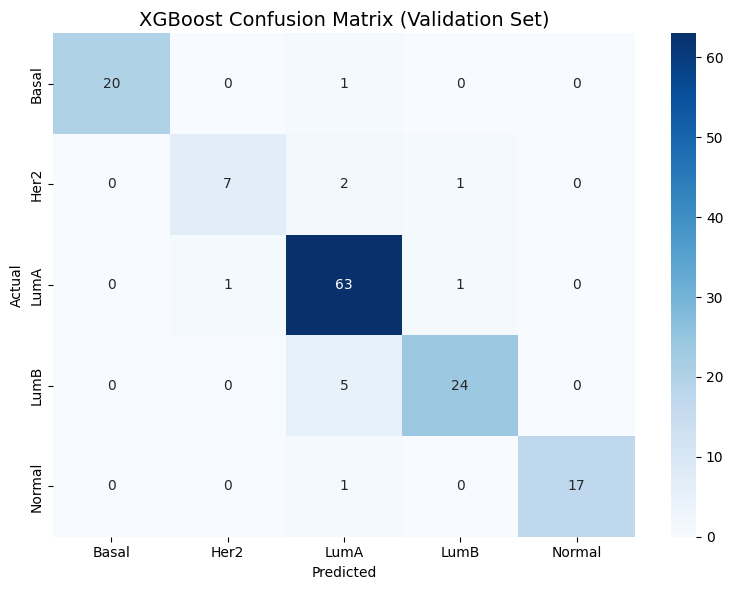

In [12]:
# Confusion Matrix
y_pred = xgb_model.predict(X_val_s)
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('XGBoost Confusion Matrix (Validation Set)', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 5. SHAP Explainability - Global Analysis

In [13]:
# Compute SHAP values for XGBoost
# Note: Due to XGBoost/SHAP compatibility, KernelExplainer is used (slower but accurate)
# Using subset of validation data for faster computation
n_shap_samples = min(50, len(X_val_s))  # Adjust this for speed vs coverage
print(f"Computing SHAP for {n_shap_samples} samples (this may take a few minutes)...")

explainer_xgb, shap_xgb = explainer.compute_shap_xgboost(xgb_model, X_val_s[:n_shap_samples])

# Check SHAP values structure
if isinstance(shap_xgb, list):
    print(f"SHAP values: {len(shap_xgb)} classes")
    print(f"Shape per class: {shap_xgb[0].shape}")
else:
    print(f"SHAP values shape: {shap_xgb.shape}")

Computing SHAP for 50 samples (this may take a few minutes)...
--- Menghitung SHAP (XGBoost)... ---
⚠️ TreeExplainer tidak kompatibel, menggunakan predict_proba wrapper...


  0%|          | 0/50 [00:00<?, ?it/s]/home/ferazzio/miniconda3/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.364e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ferazzio/miniconda3/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.746e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ferazzio/miniconda3/envs/data-science/lib/python3.10/site-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solution

✅ Perhitungan SHAP XGBoost selesai (KernelExplainer fallback).
SHAP values: 5 classes
Shape per class: (50, 20530)



=== Global Feature Importance (Beeswarm) ===
Generasi Plot Summary untuk: Basal (XGBoost)...


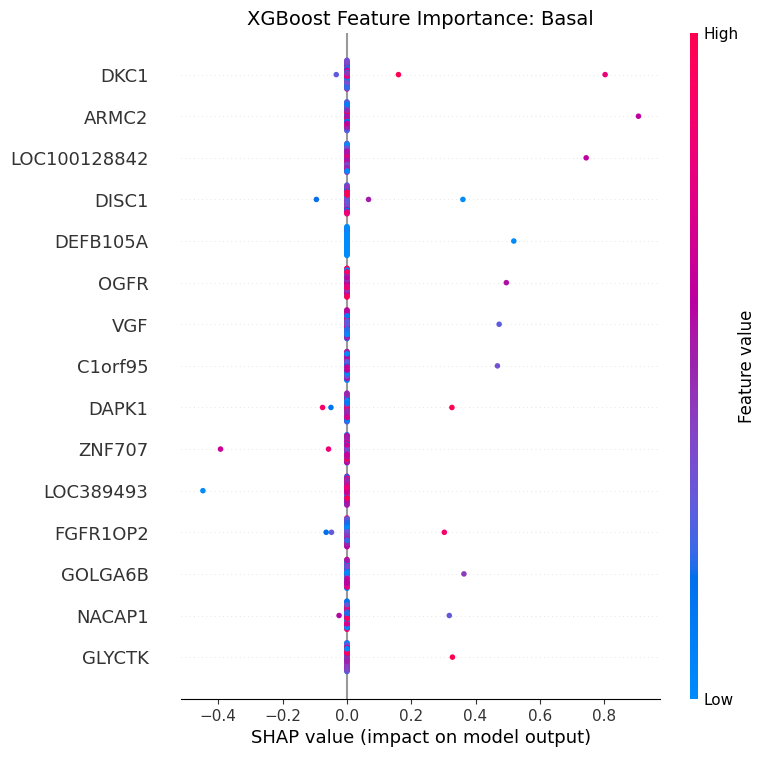

Generasi Plot Summary untuk: Her2 (XGBoost)...


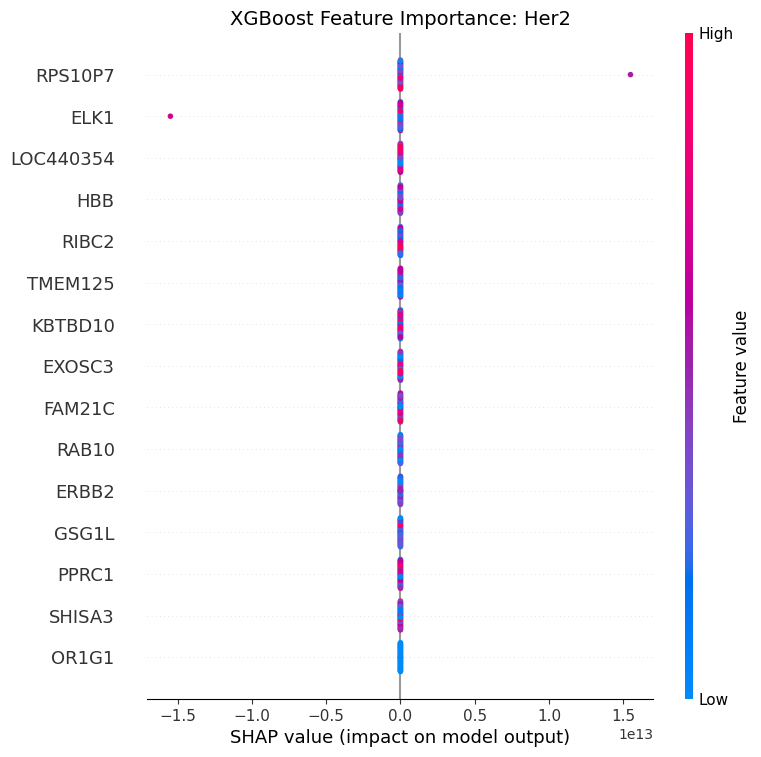

Generasi Plot Summary untuk: LumA (XGBoost)...


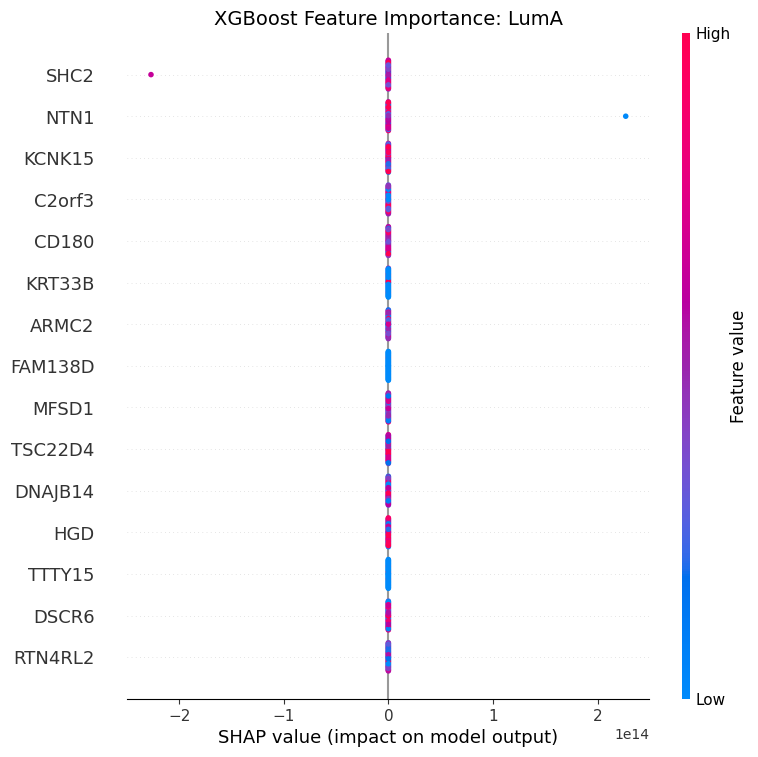

Generasi Plot Summary untuk: LumB (XGBoost)...


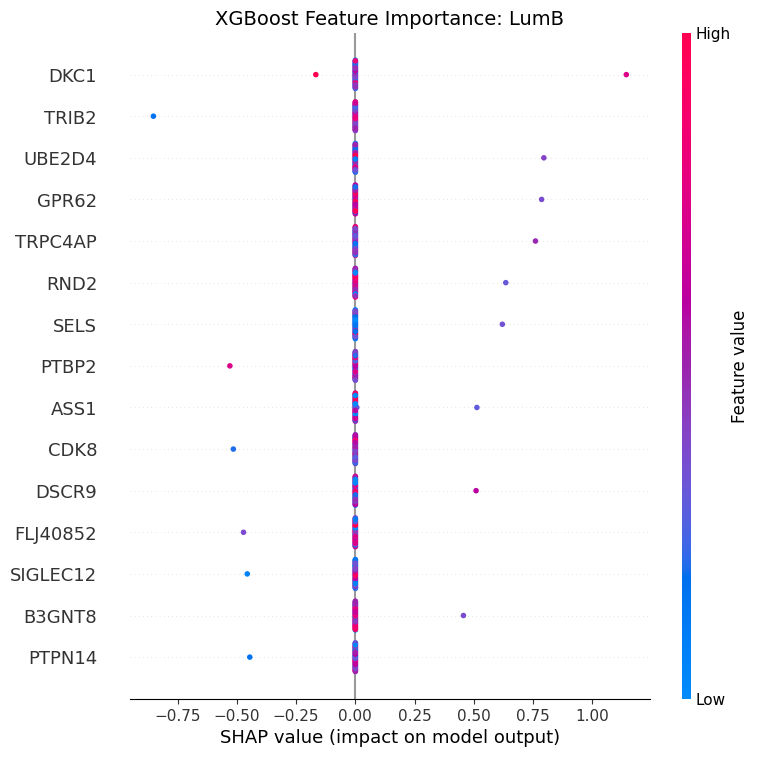

Generasi Plot Summary untuk: Normal (XGBoost)...


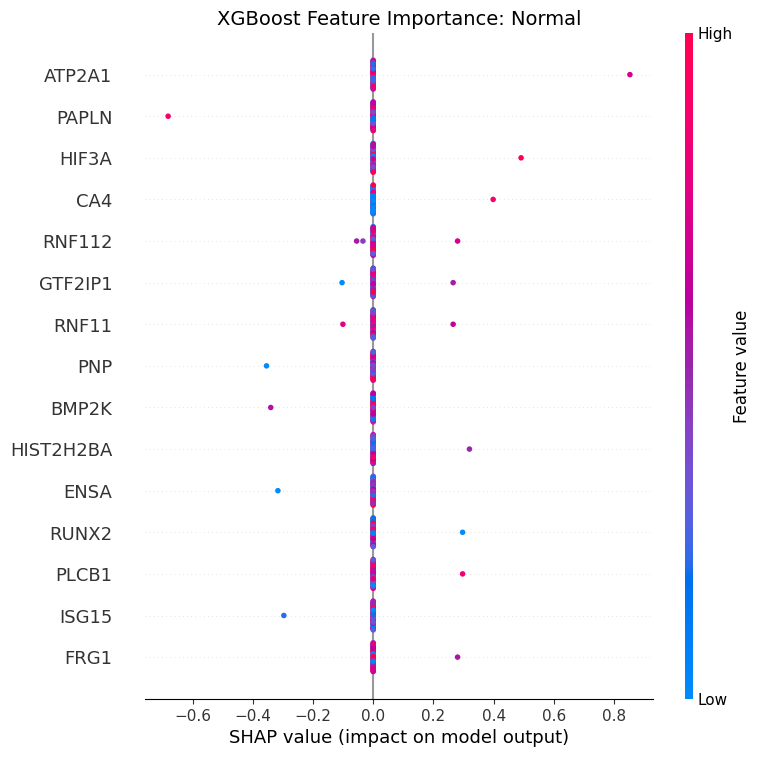

In [14]:
# Global Beeswarm Plot (All Classes)
# Using the subset of data used for SHAP computation
X_val_subset = X_val_s[:n_shap_samples]
print("\n=== Global Feature Importance (Beeswarm) ===")
viz.plot_xgboost_beeswarm(shap_xgb, X_val_subset, feature_cols, class_names, target_class='all', max_display=15)


=== Feature Importance Bar Plot ===


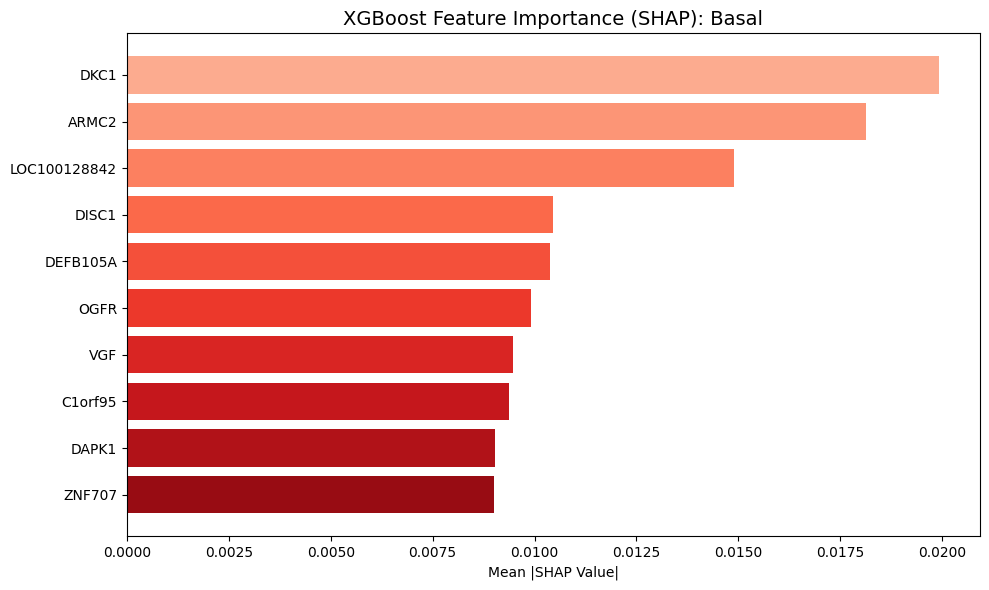

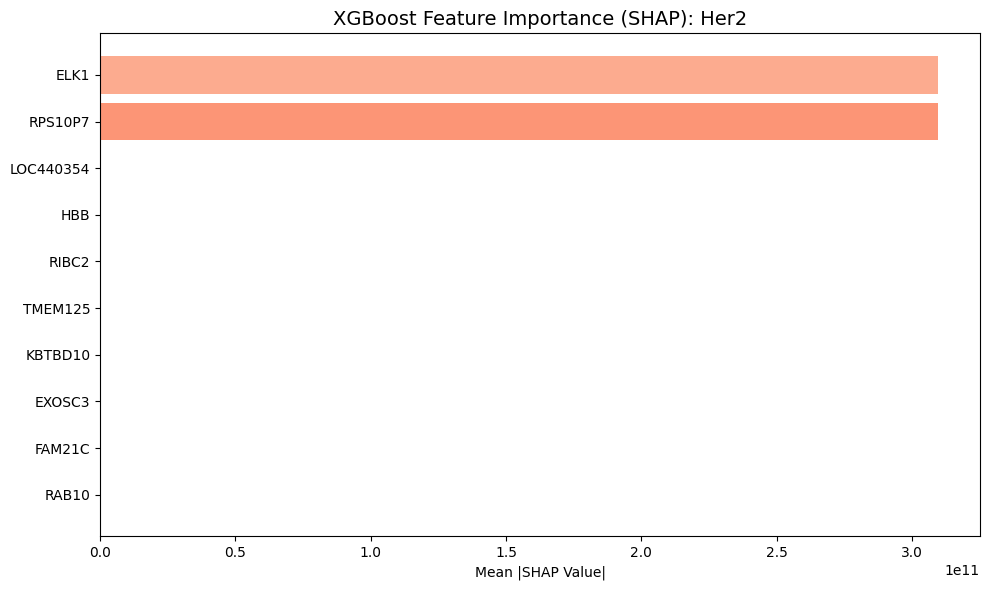

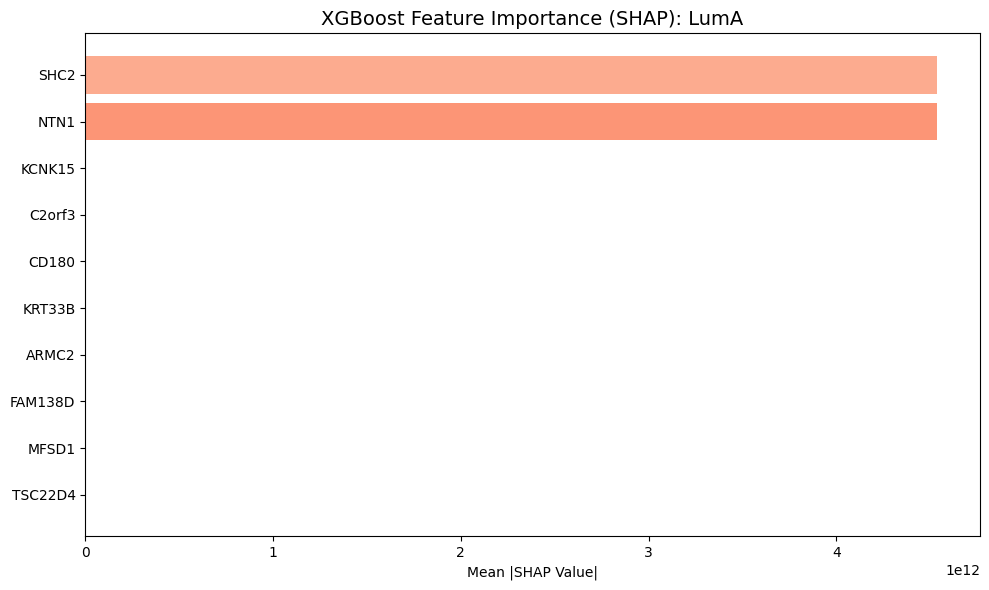

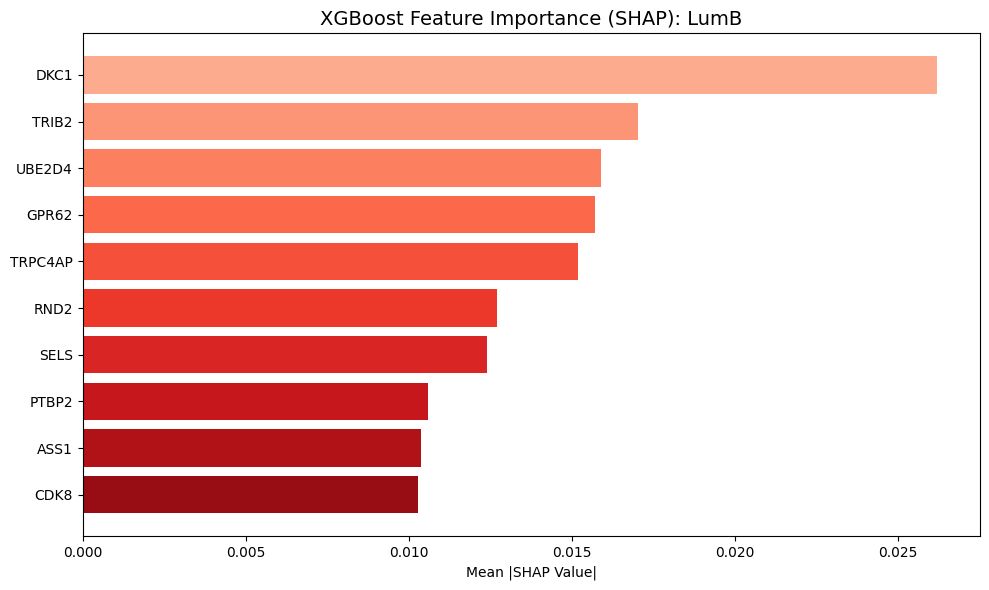

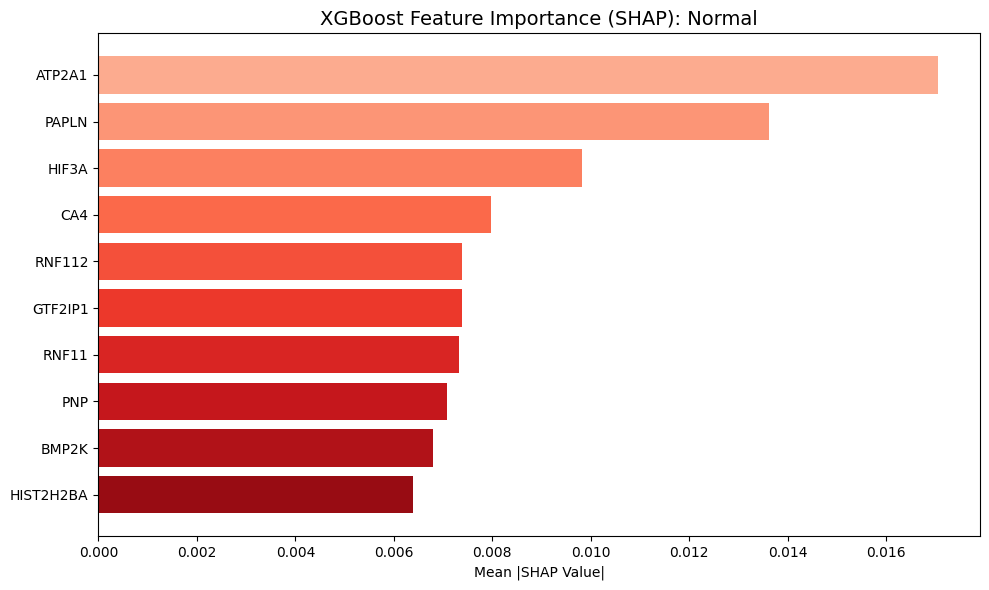

In [15]:
# Bar Plot for specific class
print("\n=== Feature Importance Bar Plot ===")
for idx, cls_name in enumerate(class_names):
    viz.plot_xgboost_bar(shap_xgb, X_val_subset, feature_cols, class_names, class_idx=idx, max_display=10)

## 6. SHAP Explainability - Local Analysis

Patient #0
Actual class: LumA
Predicted class: LumA

--- Analisis Lokal Pasien #0 (XGBoost - Kelas: LumA) ---


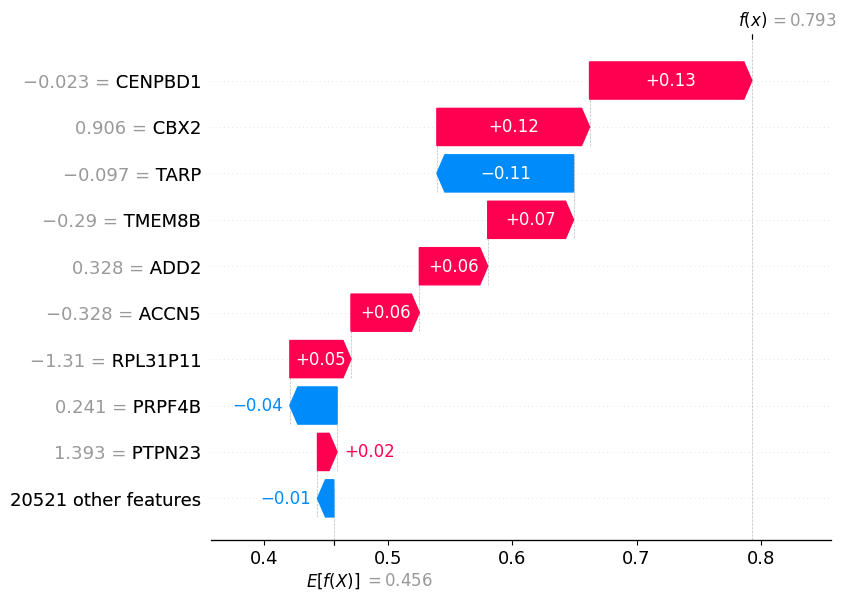

In [16]:
# Local Waterfall Plot for a specific patient
sample_idx = 0  # Change this to analyze different patients (must be < n_shap_samples)
predicted_class = xgb_model.predict(X_val_subset[sample_idx:sample_idx+1])[0]
actual_class = y_val[sample_idx]

print(f"Patient #{sample_idx}")
print(f"Actual class: {class_names[actual_class]}")
print(f"Predicted class: {class_names[predicted_class]}")

viz.plot_xgboost_waterfall(
    shap_xgb, explainer_xgb, X_val_subset, feature_cols, class_names,
    sample_idx=sample_idx, class_idx=predicted_class, max_display=10
)

In [17]:
# Force Plot
shap.initjs()
viz.plot_xgboost_force(
    shap_xgb, explainer_xgb, X_val_subset, feature_cols, class_names,
    sample_idx=sample_idx, class_idx=predicted_class
)


--- Force Plot Pasien #0 (XGBoost - Kelas: LumA) ---


## 7. Feature Dependence Analysis

In [18]:
# Find top features for dependence plot
shap_matrix = explainer.fix_shap_dimensions(shap_xgb, X_val_subset, 0)
if shap_matrix is not None:
    mean_abs_shap = np.abs(shap_matrix).mean(axis=0)
    top_features_idx = np.argsort(mean_abs_shap)[::-1][:3]
    top_features = [feature_cols[i] for i in top_features_idx]
    print(f"Top 3 features: {top_features}")

Top 3 features: ['DKC1', 'ARMC2', 'LOC100128842']


Generasi Dependence Plot untuk: DKC1 (Kelas: Basal)...


<Figure size 1000x600 with 0 Axes>

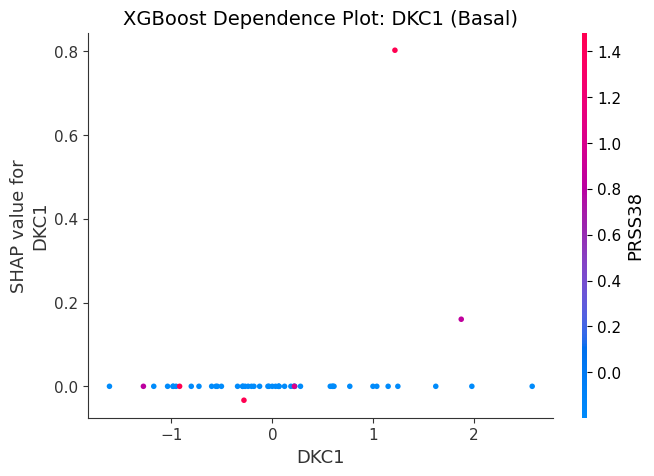

In [19]:
# Dependence Plot for top feature
if shap_matrix is not None:
    viz.plot_xgboost_dependence(
        shap_xgb, X_val_subset, feature_cols, class_names,
        feature_idx=top_features_idx[0], interaction_idx='auto', class_idx=0
    )

## 8. Decision Plot


--- Decision Plot (XGBoost - Kelas: Basal) ---


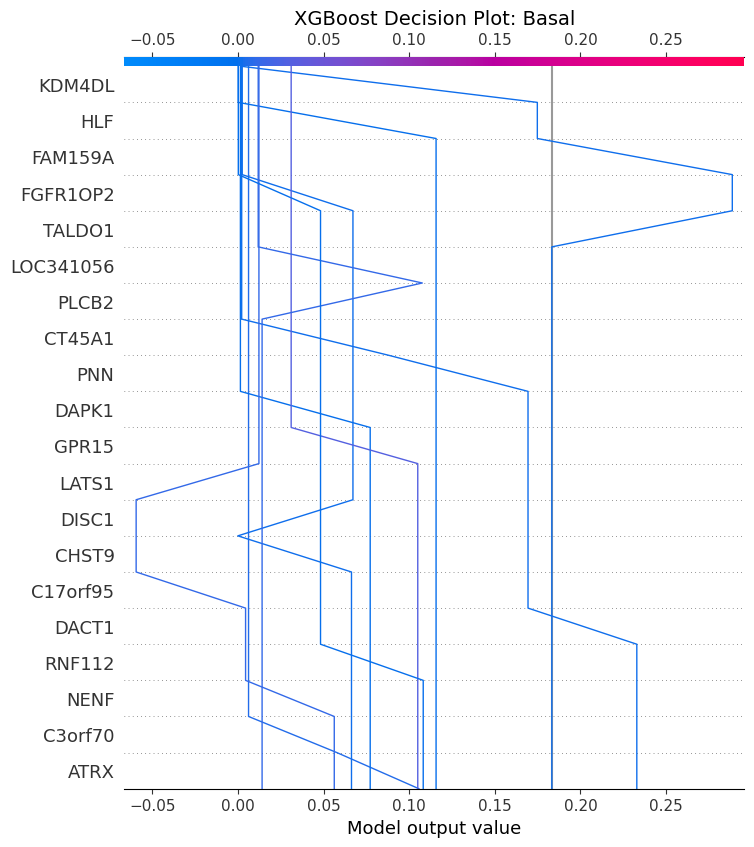

In [20]:
# Decision Plot showing prediction path
viz.plot_xgboost_decision_plot(
    shap_xgb, explainer_xgb, X_val_subset, feature_cols, class_names,
    sample_indices=list(range(min(10, n_shap_samples))), class_idx=0, max_display=15
)

## 9. Feature Interaction Analysis

In [21]:
# Compute SHAP Interaction Values (This may take a while)
COMPUTE_INTERACTIONS = False  # Set to True to compute interactions

if COMPUTE_INTERACTIONS:
    _, shap_interactions = explainer.compute_shap_xgboost_interactions(
        xgb_model, X_val_s, max_samples=50
    )
    
    # Interaction Heatmap
    viz.plot_xgboost_interaction_heatmap(
        shap_interactions, feature_cols, class_names, class_idx=0, top_n=10
    )
else:
    print("Skipping interaction analysis. Set COMPUTE_INTERACTIONS=True to enable.")

Skipping interaction analysis. Set COMPUTE_INTERACTIONS=True to enable.


## 10. Native XGBoost Feature Importance Comparison

--- Membandingkan Metode Feature Importance XGBoost... ---
--- Mengambil Feature Importance XGBoost (gain)... ---
✅ Ditemukan 1145 fitur dengan importance > 0
--- Mengambil Feature Importance XGBoost (weight)... ---
✅ Ditemukan 1145 fitur dengan importance > 0
--- Menghitung SHAP (XGBoost)... ---
⚠️ TreeExplainer tidak kompatibel, menggunakan predict_proba wrapper...


  0%|          | 0/143 [00:00<?, ?it/s]/home/ferazzio/miniconda3/envs/data-science/lib/python3.10/site-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/home/ferazzio/miniconda3/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.263e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  1%|          | 1/143 [00:03<08:30,  3.59s/it]/home/ferazzio/

✅ Perhitungan SHAP XGBoost selesai (KernelExplainer fallback).
✅ Perbandingan selesai.
Generasi Comparison Plot untuk Feature Importance...


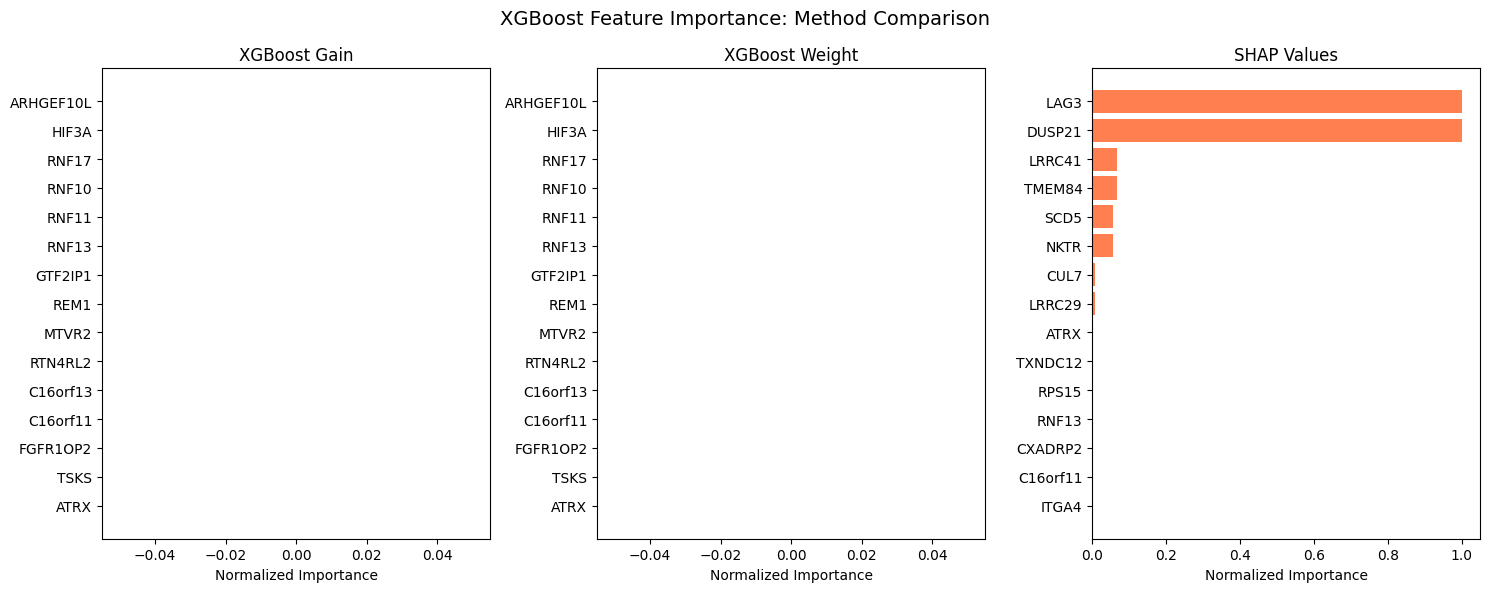

In [22]:
# Compare different importance methods
comparison = explainer.compare_xgboost_importance_methods(xgb_model, X_val_s, feature_cols)
viz.plot_xgboost_importance_comparison(comparison, feature_cols, top_n=15)

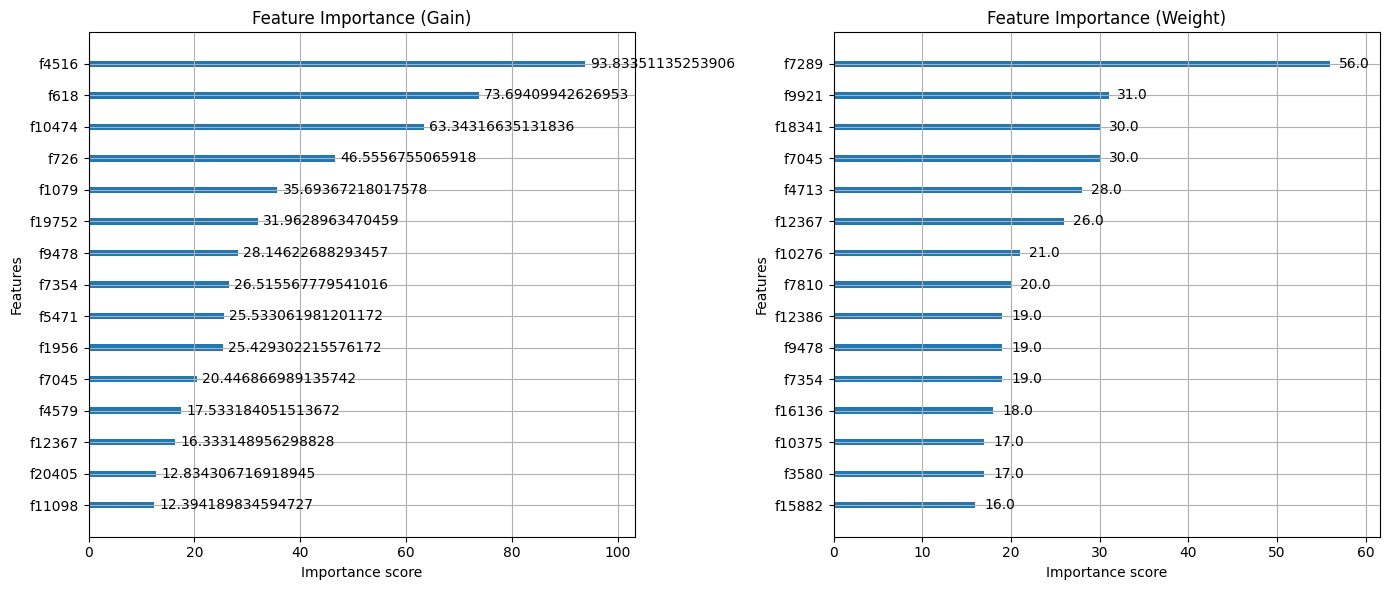

In [23]:
# Native XGBoost feature importance plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

xgb.plot_importance(xgb_model, ax=axes[0], importance_type='gain', max_num_features=15)
axes[0].set_title('Feature Importance (Gain)', fontsize=12)

xgb.plot_importance(xgb_model, ax=axes[1], importance_type='weight', max_num_features=15)
axes[1].set_title('Feature Importance (Weight)', fontsize=12)

plt.tight_layout()
plt.show()

## 11. XGBoost Tree Visualization

Generasi Tree Plot untuk tree #0...
❌ Library xgboost diperlukan untuk plot_xgboost_tree


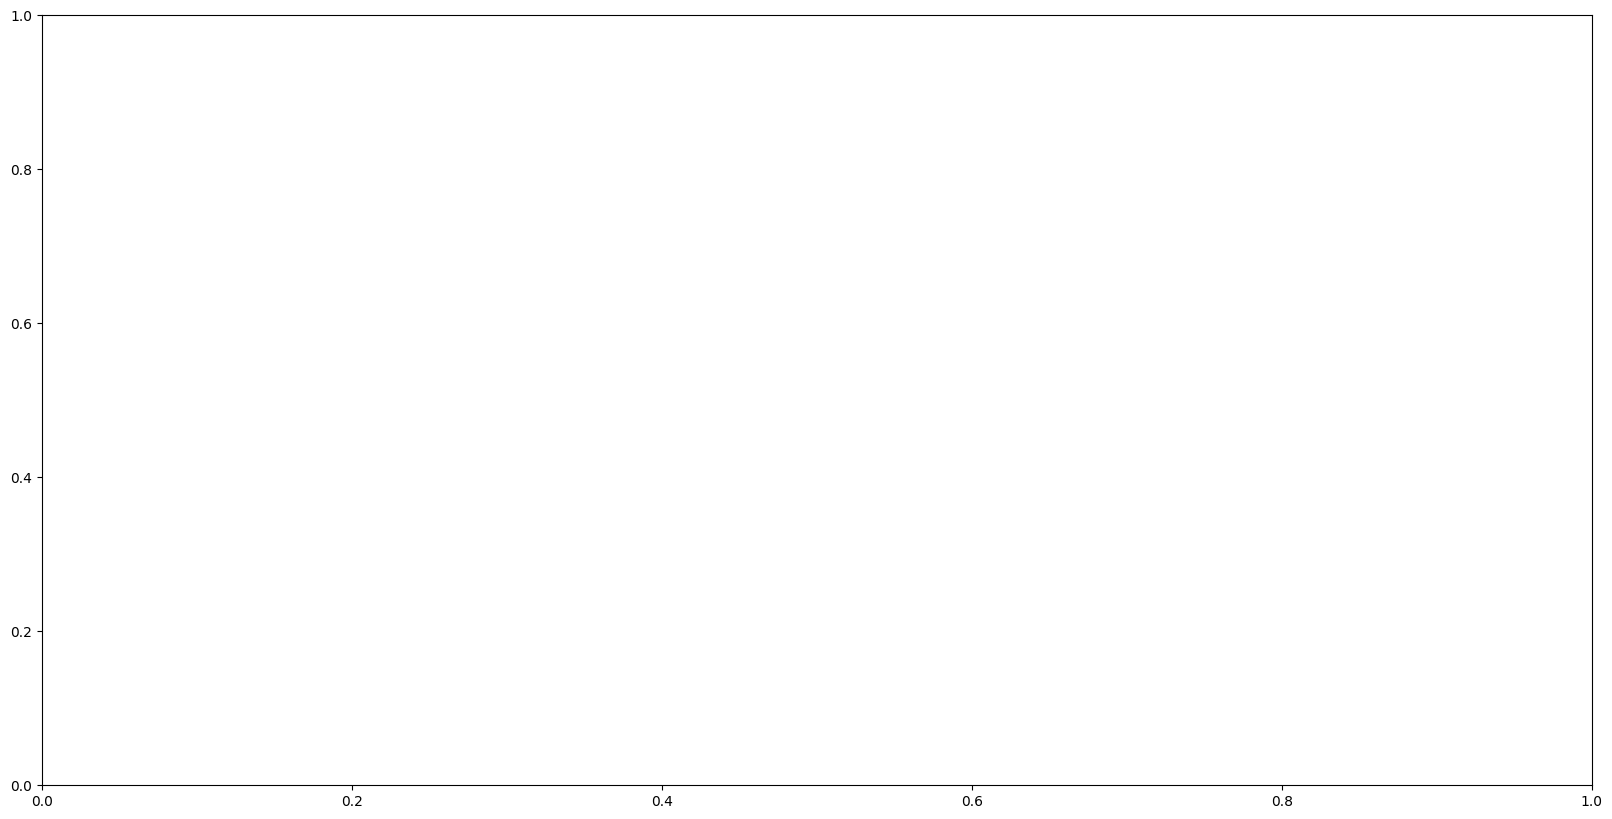

In [24]:
# Visualize a single tree
viz.plot_xgboost_tree(xgb_model, tree_index=0, figsize=(20, 10))

## 12. Save Model and Artifacts

In [25]:
# Create directory for saved models
save_dir = "Saved Model"
os.makedirs(save_dir, exist_ok=True)

# Save XGBoost model (native format - recommended)
xgb_model.save_model(os.path.join(save_dir, "xgboost_model.json"))
print(f"✅ Model saved to {save_dir}/xgboost_model.json")

# Save with joblib (alternative - includes sklearn wrapper)
joblib.dump(xgb_model, os.path.join(save_dir, "xgboost_model.joblib"))
print(f"✅ Model saved to {save_dir}/xgboost_model.joblib")

# Save scaler
joblib.dump(scaler, os.path.join(save_dir, "scaler.joblib"))
print(f"✅ Scaler saved to {save_dir}/scaler.joblib")

# Save label encoder
joblib.dump(le, os.path.join(save_dir, "label_encoder.joblib"))
print(f"✅ Label encoder saved to {save_dir}/label_encoder.joblib")

# Save feature names
joblib.dump(feature_cols, os.path.join(save_dir, "feature_cols.joblib"))
print(f"✅ Feature columns saved to {save_dir}/feature_cols.joblib")

✅ Model saved to Saved Model/xgboost_model.json
✅ Model saved to Saved Model/xgboost_model.joblib
✅ Scaler saved to Saved Model/scaler.joblib
✅ Label encoder saved to Saved Model/label_encoder.joblib
✅ Feature columns saved to Saved Model/feature_cols.joblib


## 13. Load and Verify Saved Model

In [26]:
# Load model (native format)
loaded_model = xgb.XGBClassifier()
loaded_model.load_model(os.path.join(save_dir, "xgboost_model.json"))

# Verify loaded model
loaded_pred = loaded_model.predict(X_val_s)
original_pred = xgb_model.predict(X_val_s)

print(f"Predictions match: {np.array_equal(loaded_pred, original_pred)}")
print(f"Loaded model accuracy: {accuracy_score(y_val, loaded_pred):.4f}")

Predictions match: True
Loaded model accuracy: 0.9161


In [27]:
# Load all artifacts for inference
def load_model_artifacts(save_dir):
    """Load all saved model artifacts for inference."""
    model = xgb.XGBClassifier()
    model.load_model(os.path.join(save_dir, "xgboost_model.json"))
    scaler = joblib.load(os.path.join(save_dir, "scaler.joblib"))
    label_encoder = joblib.load(os.path.join(save_dir, "label_encoder.joblib"))
    feature_cols = joblib.load(os.path.join(save_dir, "feature_cols.joblib"))
    
    return model, scaler, label_encoder, feature_cols

# Test loading
loaded_model, loaded_scaler, loaded_le, loaded_features = load_model_artifacts(save_dir)
print(f"✅ All artifacts loaded successfully")
print(f"Classes: {loaded_le.classes_}")
print(f"Number of features: {len(loaded_features)}")

✅ All artifacts loaded successfully
Classes: ['Basal' 'Her2' 'LumA' 'LumB' 'Normal']
Number of features: 20530


## 14. Summary

In [28]:
# Final Summary
print("=" * 60)
print("XGBoost Model Summary")
print("=" * 60)
print(f"\nDataset:")
print(f"  - Total samples: {len(df)}")
print(f"  - Features: {len(feature_cols)}")
print(f"  - Classes: {list(class_names)}")

print(f"\nModel Performance:")
val_acc = accuracy_score(y_val, xgb_model.predict(X_val_s))
test_acc = accuracy_score(y_test, xgb_model.predict(X_test_s))
print(f"  - Validation Accuracy: {val_acc:.4f}")
print(f"  - Test Accuracy: {test_acc:.4f}")

print(f"\nModel Parameters:")
params = xgb_model.get_params()
print(f"  - n_estimators: {params['n_estimators']}")
print(f"  - max_depth: {params['max_depth']}")
print(f"  - learning_rate: {params['learning_rate']}")

print(f"\nSaved Artifacts:")
for f in os.listdir(save_dir):
    print(f"  - {f}")

XGBoost Model Summary

Dataset:
  - Total samples: 956
  - Features: 20530
  - Classes: ['Basal', 'Her2', 'LumA', 'LumB', 'Normal']

Model Performance:
  - Validation Accuracy: 0.9161
  - Test Accuracy: 0.8750

Model Parameters:
  - n_estimators: 100
  - max_depth: 6
  - learning_rate: 0.1

Saved Artifacts:
  - scaler.joblib
  - feature_cols.joblib
  - xgboost_model.json
  - xgboost_model.joblib
  - label_encoder.joblib
